# Homework 2
### ASTR518
### Noah Franz

In [1]:
#imports
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimezoneInfo

import astroplan as planner
from astroplan.plots import plot_airmass 


# See pdf prepending this for Problem 1

# Problem 2 Code (See pdf prepending this for explanations)

In [2]:
@dataclass
class Instrument:
    
    name:str
    area:float
    throughput:float
    gain:float
    n_pix:float
    dark_noise:float
    read_noise:float
    q: float # quantum efficiency
    plate_scale: float
    d_pix : float = 1.5e-4 # the pixel size in mm
    sky_brightness:float = 22 # the sky brightness in mag/arcsec^2
    
    def __post_init__(self, *args, **kwargs):
        
        self.sky_scatter = self.f_V(self.sky_brightness).to(u.ct/u.s/u.arcsec**2)
    
    def f_V(
            self,
            mag:float,
            lambda_eff:u.Quantity=0.545*u.um, # for V mag
            f0:u.Quantity=363.1e-11*u.erg/(u.cm**2 * u.s * u.AA) # for V mag
        ) -> u.Quantity:
        return f0*10**(-0.4*mag) * self.area * lambda_eff**2 / (c.h*c.c) *u.ct/u.arcsec**2
    
    def f_V_count(
            self,
            mag:float,
            lambda_eff:u.Quantity=0.545*u.um, # for V mag
            f0:u.Quantity=363.1e-11*u.erg/(u.cm**2 * u.s * u.AA) # for V mag
        ) -> u.Quantity:
        
        return self.n_pix * self.throughput * (self.plate_scale*self.d_pix)**2 * self.f_V(mag, lambda_eff=lambda_eff, f0=f0) * u.arcsec**2 / u.pixel
    
    def f_V_electrons(
            self,
            mag:float,
            lambda_eff:u.Quantity=0.545*u.um, # for V mag
            f0:u.Quantity=363.1e-11*u.erg/(u.cm**2 * u.s * u.AA), # for V mag
            **kwargs
        ) -> float:
        return self.q * self.f_V_count(mag, lambda_eff=lambda_eff, f0=f0).to(u.ct/u.s/u.pixel).value
    
    def obst(self, mag, SNR_goal=5, **kwargs):
        N_star = self.f_V_electrons(mag, **kwargs) # electrons / s / pixel
        S_e = self.f_V_electrons(mag, **kwargs) # electrons / s / pixel
        
        a = N_star**2
        b = -SNR_goal**2 * (N_star + self.dark_noise*self.n_pix/3600 + S_e)
        c = -SNR_goal**2 * self.read_noise**2 * self.n_pix

        return np.roots((a,b,c)).max()

In [3]:
n_pix_bok = 4 * (4096**2) * u.pix
A_Bok = np.pi*(2.29*u.m/2)**2
T_bok = 0.8578
g_bok = 2
D_bok = 3 # electrons / pixel / hour
n_pix_bok = (4096**2) #4*(4096**2)
R_bok = 12

Bok = Instrument(
    name="Bok 90Prime",
    area=A_Bok,
    throughput=T_bok,
    gain=g_bok,
    n_pix=n_pix_bok,
    dark_noise=D_bok,
    read_noise=R_bok,
    q=0.90,
    plate_scale=9.66 # in "/mm
)

Bok

Instrument(name='Bok 90Prime', area=<Quantity 4.11870651 m2>, throughput=0.8578, gain=2, n_pix=16777216, dark_noise=3, read_noise=12, q=0.9, plate_scale=9.66, d_pix=0.00015, sky_brightness=22)

In [4]:
A_kuiper = np.pi * (1.54*u.m)**2

T_kuiper = T_bok

g_kuiper = 3.1
D_kuiper = 16.6 # electrons / pixel / hour
n_pix_kuiper = 4096 * 4097
R_kuiper = 5

Kuiper = Instrument(
    name = 'Kuiper 61" Mont4k',
    area = A_kuiper,
    throughput = T_kuiper,
    gain = g_kuiper,
    n_pix = n_pix_kuiper,
    dark_noise = D_kuiper,
    read_noise = R_kuiper,
    q=0.88,
    plate_scale = 10.0 # "/mm
)

Kuiper

Instrument(name='Kuiper 61" Mont4k', area=<Quantity 7.45060114 m2>, throughput=0.8578, gain=3.1, n_pix=16781312, dark_noise=16.6, read_noise=5, q=0.88, plate_scale=10.0, d_pix=0.00015, sky_brightness=22)

In [5]:
# part (f)


f_bok = Bok.f_V(22).to(u.ct/u.s/u.arcsec**2)
f_bok

<Quantity 354.40787805 ct / (s arcsec2)>

In [6]:
Bok.f_V_count(22).to(u.ct/u.s/u.pixel)

<Quantity 10708.92990546 ct / (pix s)>

In [7]:
# part (g)

Bok.obst(mag=15)

0.04041725761322866

In [8]:
print(Kuiper.sky_scatter)
print(Kuiper.f_V_count(22).to(u.ct/u.s/u.pixel))

Kuiper.obst(mag=15)

641.1118960971799 ct / (s arcsec2)
20764.826532702195 ct / (pix s)


0.008884814334819278

# Problem 3

_Potential Target 1 : AT2024pvu (Confirmed TDE but old!)_
* Discovery Date: July 10, 2024 (This is old :( )
* Coordinates: 23:31:11.903 +22:15:32.14
* Magnitude between 17 and 19 (17 as of 08/26, that was a month ago so likely will just capture host contamination at magnitude ~19)
* z ~ 0.048
* TNS Link: https://www.wis-tns.org/object/2024pvu

_Potential Target 2 : AT2024ule (unconfirmed, but suspected, TDE)_
* Coordinates: 08:14:27.141 +09:00:01.47
* Magnitude: 18.84 on 10/10
* z ~ Unknown
* TNS Link: https://www.wis-tns.org/object/2024ule

_Potential Target 3 : AT 2024vpg (unconfirmed, but suspected, TDE)_
* Coordinates: 19:47:23.194 +57:35:28.84
* Magnitude 19.7 on 09/22, probably still brightening!
* Z ~ Unknown
* TNS Link: https://www.wis-tns.org/object/2024vpg

### Part 3a/b/c

In [9]:
obs = planner.Observer.at_site('mtbigelow')
obs_date = Time("2024-10-19 02:00:00", format="iso") + 7*u.hour # we are observing on the night of Oct 18, 2024 - Oct 19, 2024, converted to utc
tz = TimezoneInfo(utc_offset=-7*u.hour)

In [10]:
pvu_coords = SkyCoord("23:31:11.903", "+22:15:32.14", unit=("hour", "deg"))
pvu = planner.FixedTarget(name='AT2024pvu', coord=pvu_coords)

ule_coords = SkyCoord("08:14:27.141", "+09:00:01.47", unit=("hour", "deg"))
ule = planner.FixedTarget(name='AT2024ule', coord=ule_coords)

vpg_coords = SkyCoord("19:47:23.194", "+57:35:28.84", unit=("hour", "deg"))
vpg = planner.FixedTarget(name='AT2024vpg', coord=vpg_coords)

wsd_coords = SkyCoord("05:26:38.327", "-17:54:54.60", unit=("hour", "deg"))
wsd = planner.FixedTarget(name="AT2024wsd", coord=wsd_coords)

targets = dict(
    AT2024pvu = pvu,
    AT2024ule = ule,
    AT2024vpg = vpg,
    AT2024wsd = wsd,
)

In [11]:
for name, t in targets.items():
    rise_time = obs.target_rise_time(obs_date, t) + 5*u.minute
    set_time = obs.target_set_time(obs_date, t) - 5*u.minute
    
    print(f"{name} is up from {rise_time.iso} - {set_time.iso}")

AT2024pvu is up from 2024-10-18 22:08:09.906 - 2024-10-19 11:57:15.174
AT2024ule is up from 2024-10-19 07:27:45.672 - 2024-10-19 20:01:28.276
AT2024vpg is up from                     ——— -                     ———
AT2024wsd is up from 2024-10-19 05:50:12.089 - 2024-10-19 16:03:51.036


In [12]:
sunset_tonight = obs.sun_set_time(obs_date, which='nearest')
sunrise_tonight = obs.sun_rise_time(obs_date, which='nearest')

sunset_tonight.iso, sunrise_tonight.iso

('2024-10-19 00:41:54.550', '2024-10-19 13:34:14.868')

In [13]:
for name, t in targets.items():
    rise_time = obs.target_rise_time(obs_date, t) + 5*u.minute
    set_time = obs.target_set_time(obs_date, t) - 5*u.minute
    
    start = np.max([sunset_tonight, rise_time])
    stop = np.min([sunrise_tonight, set_time])
    
    print(f"{name} is available to observe from {start.iso} - {stop.iso}")

AT2024pvu is available to observe from 2024-10-19 00:41:54.550 - 2024-10-19 11:57:15.174
AT2024ule is available to observe from 2024-10-19 07:27:45.672 - 2024-10-19 13:34:14.868
AT2024vpg is available to observe from                     ——— -                     ———
AT2024wsd is available to observe from 2024-10-19 05:50:12.089 - 2024-10-19 13:34:14.868


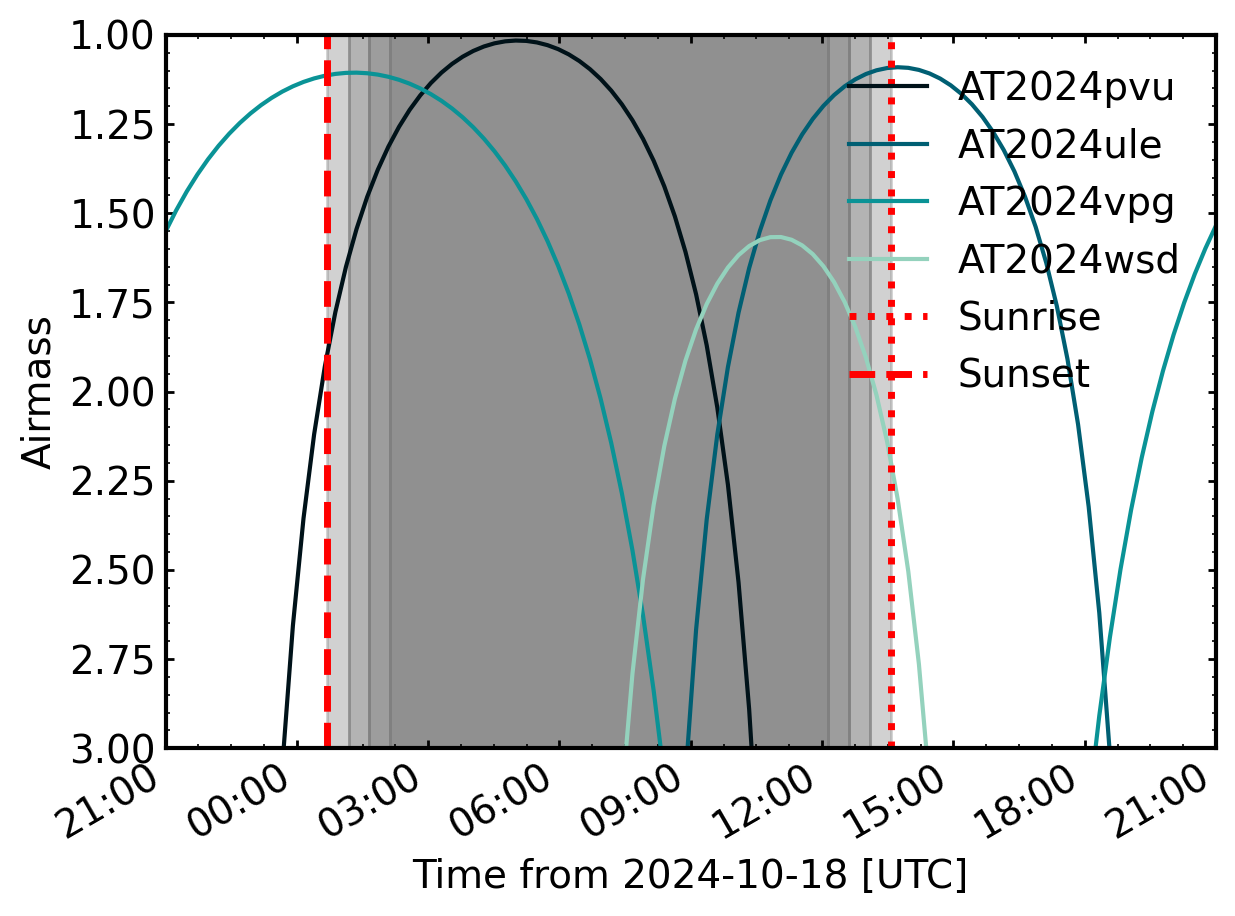

In [14]:
for name, t in targets.items():
    plot_airmass(t, obs, obs_date, brightness_shading=True) 

plt.axvline(sunrise_tonight.plot_date, color='r', linestyle=':', label='Sunrise')
plt.axvline(sunset_tonight.plot_date, color='r', linestyle='--', label='Sunset')

plt.legend(loc=1, bbox_to_anchor=(1, 1)) 

plt.show() 

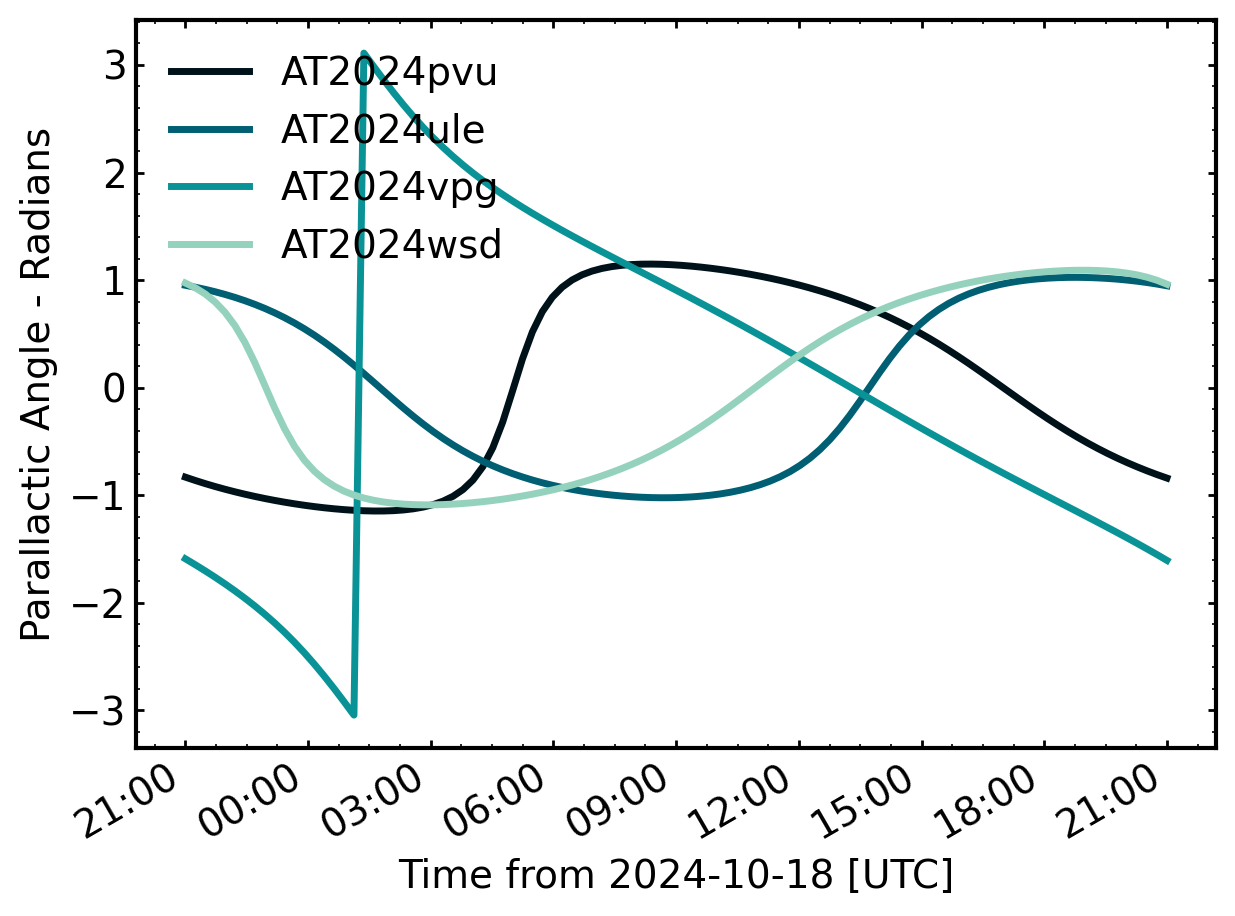

In [15]:
import matplotlib.pyplot as plt 

from astroplan.plots import plot_parallactic 

for name, t in targets.items():
    plot_parallactic(t, obs, obs_date)
    
plt.legend(loc=2) 

plt.show() 


### Part 3d

Now plan an observing schedule for these three targets

First step is to compute how long we need to be on each of these targets for SNR 5

In [26]:
target_mags = dict(
    AT2024pvu = 19,
    AT2024ule = 18.8,
    AT2024vpg = 19,
    AT2024wsd = 18.3
)

target_time = dict(
    AT2024pvu = None,
    AT2024ule = None,
    AT2024vpg = None,
    AT2024wse = None
)
SNR_wanted = 100

tele = Bok

for name, target_mag in target_mags.items():
    t = tele.obst(target_mag, SNR_goal=SNR_wanted)
    target_time[name] = t
    print(f"{name} must be observed for {t:.2f}s for SNR={SNR_wanted}")

AT2024pvu must be observed for 32.25s for SNR=100
AT2024ule must be observed for 26.82s for SNR=100
AT2024vpg must be observed for 32.25s for SNR=100
AT2024wsd must be observed for 16.92s for SNR=100


Since these exposure times are so short, a good observing plan would be something like (Note: all times are in UTC) the following, where I give a half hour for each target so we can get multiple exposures with multiple filters. 

1. AT2024vpg at the beginning of the night from 01:30 to 02:00
2. AT2024pvu anytime between 02:00 and 07:00
3. AT2024ule from 12:00 to 12:30

### Part 3e

/tmp/ipykernel_1921282/3987848271.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


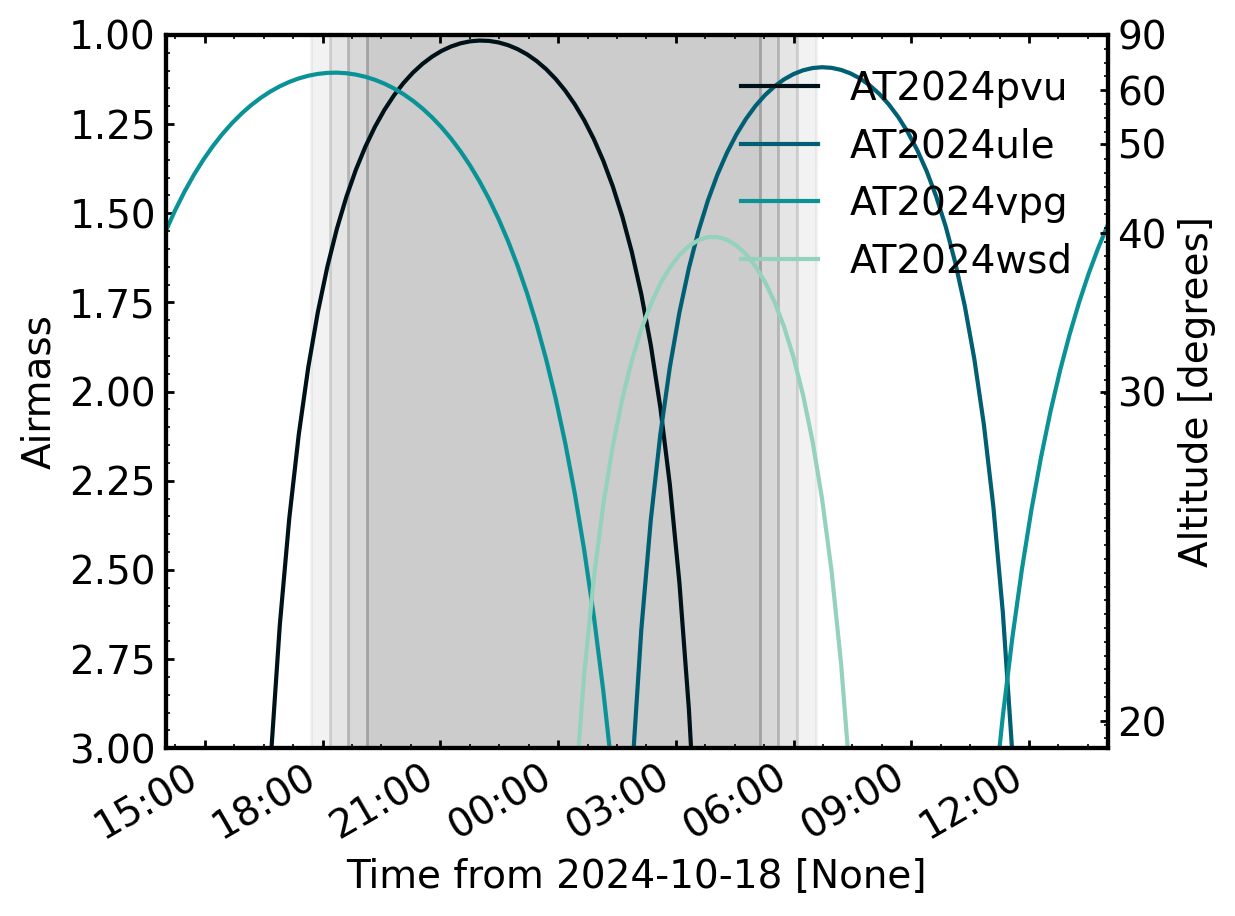

In [21]:
fig, ax = plt.subplots()

ax = plot_airmass(
    list(targets.values()), 
    obs, 
    obs_date.to_datetime(timezone=tz), 
    ax=ax, 
    use_local_tz=True, 
    brightness_shading=True,
    altitude_yaxis=True
) 

ax.legend(loc=1, bbox_to_anchor=(1, 1)) 

fig.savefig("airmass-plot.png")

fig.show() 

# Problem 4

### Part (a)
I will do this problem on AT2024pvu which is at (RA, Dec) = (23:31:11.903 +22:15:32.14), redshift z~0.048, and an unknown V-mag. Instead, I will use the most recent ZTF g-band magnitude of ~17

### Part (b)

In [18]:
mag_g = 17
f0 = 466.9e-11 * u.erg / (u.s * u.cm**2 * u.AA)
lambda_eff = 0.483 * u.um

flux = (f0*10**(-0.4*mag_g)) / (c.h*c.c / lambda_eff) * u.ct
flux.to(u.ct / (u.AA * u.cm**2 * u.s))

<Quantity 0.00017993 ct / (Angstrom s cm2)>

### Part (c) & (d)

In [19]:
snrs = [5, 100]

for snr in snrs:
    t = Bok.obst(mag_g, SNR_goal=snr, f0=f0, lambda_eff=lambda_eff)
    print(f"For a target SNR={snr}, the exposure time required is t={t:.3e} s")

For a target SNR=5, the exposure time required is t=2.525e-01 s
For a target SNR=100, the exposure time required is t=5.060e+00 s


### Part (e)

An SNR=100 is favorable over an SNR=5 because the signal is likely to be much stronger compared to the background noise. This means that the probability of a detection is significantly higher and the quality of the signal for later analysis is much much better.

### Part (f)

Note that since this is a transient, the magnitude will likkely be higher than 17 since ZTF took the data ~1 month ago. We may instead capture mostly host contamination which has a magnitude of ~19. This will result in exposure times of instead 2s for SNR=5 and 32s for SNR=100, both of which are still very manageable!

# Problem 5

In [20]:
n_pix = 1200*800
R = 8.11 # angstroms / res element
Disp = 3.72 # angstroms / pix

Bok_BC = Instrument(
    name="Bok B&C Spec",
    area=A_Bok,
    throughput=0.1,
    gain=1.5,
    n_pix=n_pix,
    dark_noise=5.4,
    read_noise=2.7,
    q=0.40,
    plate_scale=9.66 # in "/mm
)

f_pix = Bok_BC.f_V_count(19).to(u.ct/u.s/u.pix)
f = f_pix * (R/Disp)
print(f)

S_gamma = Bok_BC.f_V_count(22).to(u.ct/u.s/u.pix) * (R/Disp)
print(S_gamma)

def SNR(t, f=f.value, Q=Bok_BC.q, D=Bok_BC.dark_noise, R=Bok_BC.read_noise, n_pix=Bok_BC.n_pix, S_gamma=S_gamma.value):
    return f*t*Q / (f*t*Q + R*n_pix + D*n_pix*t/3600 + S_gamma*t*Q)**0.5

SNR(120)

2468.2507944011345 ct / (pix s)
155.73609667464672 ct / (pix s)


69.68272932228919

# Problem 6

The code given for review is 
```
import numpy as np

def c s n r ( s , t , rn , bg , dc , z o d i # t o d
)
    # CALCULATE SN
    i f t < 0
        print ( " t < 0 , answer would be wrong "
        return -1
    n = s ∗ t
    s = s ∗ t
    n += rn ∗∗2
    n += bg ∗ t
    n += dc ∗ t
    # import square −r o o t f u n c t i o n from NumPy ( H a r r i s 2020)
    from numpy import s q r t
    n = s q r t ( n )
    s /= n
    print ( " s n r =" , s )
    return s
```

**Response:** 

Dear colleague,

Thank you for sharing your code with me, I know that it can be scary to perform a code review. I've numbered my suggestions below.

1. It is best practice to use descriptive variable names so that when code goes under review it is clear what each element is doing. For example, instead of using `s` you should use the variable name `signal`.
2. According to pep8 (the python style guide):
    * each function should have a docstring which outlines each variable that you are inputting. This can be done with the "three quote" notation, for example
    * Additionally, the function definition should either be on a single line less than 80 characters or split across multiple lines.
    * Finally, the function definition should use type hints
   
   A sample function showing changes like these is shown below!
   ```
   from typing import Optional
   def add(x:float, y:Optional[float]=0) -> float:
       """
       Adds two numbers together

       Args:
           x (float) : The first value to be added
           y (float) : The second value to be added

       Returns:
           The sum of x and y, as a float.
       """
       return x + y
   ```
3. You should try to avoid imports inside functins (with a few exceptions), this is in case you (or other users) are iterating over the function. You can imagine that if I iterated over importing a large library like numpy a million times it would take up a lot of time! Instead, you can move the import statements outside of the functions at the top of the file. On the note of import statements, you should use imports like `import numpy as np` and then call numpy functions, like sqrt, as `np.sqrt(...)` throughout your code (see your line 15).
4. A lot of your code (lines 9 to 13) seem to just be defining the noise term of the SNR. This should be done in one line for readability. So instead of what you have, maybe something like `noise = np.sqrt(s*t + rn**2 + bg*t + dc*t)`. This would be much more readable for scientists who are coming back to read the code. Similarly, your s variable (I assume signal) could then just be returned as `return signal/noise` which is much more readable and like what a reviewer would expect! 
5. According to pep8, extraneous print statements are usually bad practice. This is because when iterating over the function (say a million times) those print statements will clog up your code logging and slow down the code significantly. For example, imagine a user is catching all of your print statements and writing them to a log, that writing will slow everything down significantly! In your code, I would recommend getting rid of the two print statements (lines 7 and 18) and just printing the result of the function instead.
6. You check for if the time is less than zero which is, as you point out, unphysical. You should probably also perform input validation for the other input values.
7. In general, I would suggest more comments in your code. These don't need to be every line but block commenting every few lines would be helpful to any code reviewer to understand what the next few lines are supposed to do.

Good luck and let me know if you have any questions!

Noah